In [1]:
import itertools as it
import os

from iterpop import iterpop as ip
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: 32716a2756a3
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: perfect-tree-phylometrics
nbpath: /opt/hstrat-evolutionary-inference/binder/perfect-tree-phylometrics.ipynb
revision: null
session: d7ea1250-358c-4f58-8c55-dd34b6189308
timestamp: 2023-04-09T00:53:41Z00:00


IPython==7.16.1
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.11.0
teeplot==0.5.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.0.3
json==2.0.9
six==1.16.0
ipykernel==5.5.3


In [3]:
df = pd.read_csv("https://osf.io/5trmg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


40f23b7946d11896


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2.677385e+06,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2.726867e+06,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2.835695e+06,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2.499463e+06,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2.477275e+06,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104994,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,24.562416,24.562416,1,3305,99.163609,3.242650e+04,282.320163,30.0,0.01,naive
104995,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,16,...,17.300466,17.300466,0,2923,1893.146789,6.190590e+05,250803.885040,100.0,0.01,rollback
104996,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,1,...,88.702783,88.702783,1,717008,5.744125,1.882235e+05,6.163179,100.0,1.00,rollback
104997,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,25.685331,25.685331,0,516453,28.659882,9.391270e+05,116.954707,3.0,1.00,naive


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104955,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,25,...,86.927779,86.927779,1,724151,6.498184,212932.5,6.463885,100.0,1.0,naive
104957,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,19,...,41.519441,41.519441,1,564013,4.646164,152245.5,2.874790,30.0,1.0,naive
104969,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,17,...,72.132664,72.132664,1,685644,5.576447,182729.0,3.720116,30.0,1.0,naive
104970,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,3,...,29.663459,29.663459,0,527010,29.281845,959507.5,121.981043,3.0,1.0,naive


In [10]:
# exclude extraneous variable values
df = df[(df["a"] == "collapsed-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100194,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,35,...,27.905306,27.905306,0,557266,62.567078,2050198.0,699.189837,NaN,NaN,NaN
100195,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,30,...,30.100132,30.100132,0,554954,54.291748,1779032.0,501.593774,NaN,NaN,NaN
100196,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,49,...,31.654246,31.654246,0,549085,61.928589,2029276.0,1052.942164,NaN,NaN,NaN
100197,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,42,...,23.908626,23.908626,0,532354,65.404114,2143162.0,870.762049,NaN,NaN,NaN


In [11]:
df["num_niches"].unique()


array([4, 1, 8])

In [12]:
df["num_islands"].unique()


array([1024,    1])

In [13]:
df["tournament_size"].unique()


array([2, 1, 4])

In [14]:
df["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2, 3.0517578125e-08): "plain",
        (1, 1, 1, 3.0517578125e-08): "weak selection",
        (1, 1, 4, 3.0517578125e-08): "strong selection",
        (1, 1, 8, 3.0517578125e-08): "weak selection",
        (1, 4, 2, 3.0517578125e-06): "weak 4 niche ecology",
        (1, 4, 2, 3.0517578125e-08): "4 niche ecology",
        (1, 8, 2, 3.0517578125e-08): "8 niche ecology",
        (1024, 1, 2, 3.0517578125e-08): "spatial structure",
    }.get(
        tuple(
            row[
                [
                    "num_islands",
                    "num_niches",
                    "tournament_size",
                    "p_niche_invasion",
                ]
            ]
        ),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'weak selection',
       'plain', 'strong selection', 'spatial structure',
       '8 niche ecology'], dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'weak selection',
       'plain', 'strong selection', 'spatial structure',
       '8 niche ecology'], dtype=object)

# Phylometrics by Regime, Perfect Data


In [17]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=(
        evolutionary_variables
        + methodological_variables
        + sensitivity_analysis_variables
        + ["regime"]
    ),
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_islands,num_niches,tournament_size,p_niche_invasion,resolution,epoch,mut_distn,regime,variable,value,phylometric
0,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,346237.149255,colless_like_index
1,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,393531.329296,colless_like_index
2,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,358279.386159,colless_like_index
3,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,435516.244222,colless_like_index
4,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,378408.625158,colless_like_index
...,...,...,...,...,...,...,...,...,...,...,...
8395,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean_evolutionary_distinctiveness,19.401215,mean_evolutionary_distinctiveness
8396,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean_evolutionary_distinctiveness,19.637848,mean_evolutionary_distinctiveness
8397,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean_evolutionary_distinctiveness,1.908936,mean_evolutionary_distinctiveness
8398,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean_evolutionary_distinctiveness,1.918182,mean_evolutionary_distinctiveness


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=7+mut_

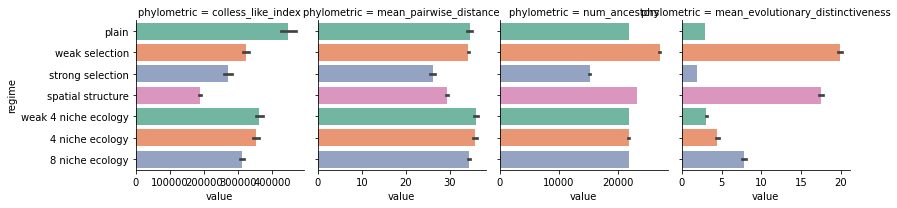

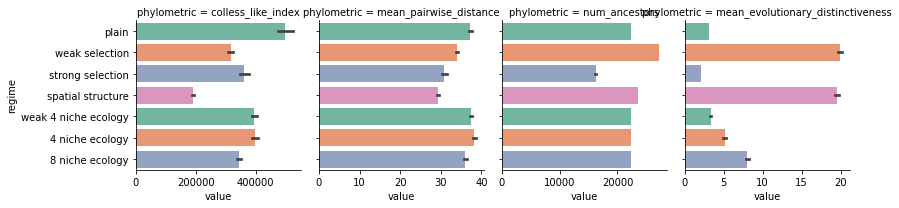

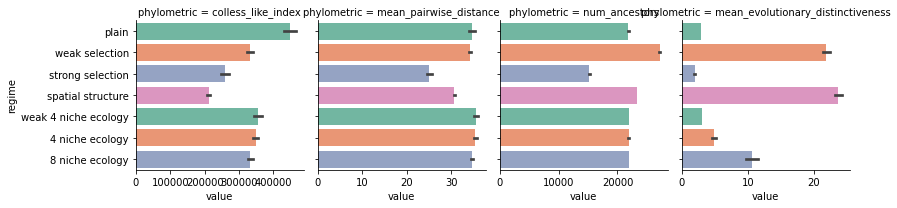

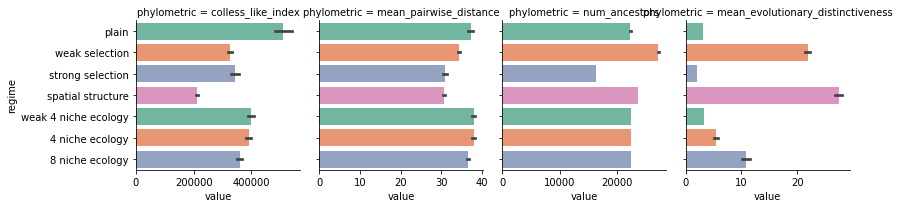

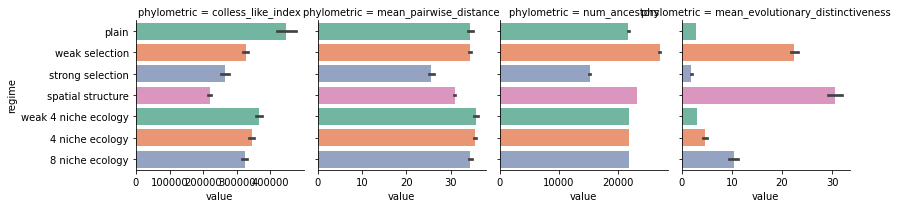

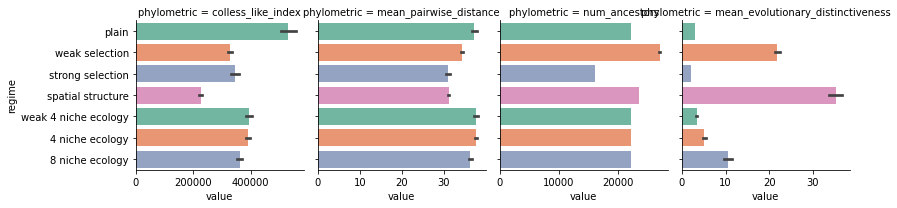

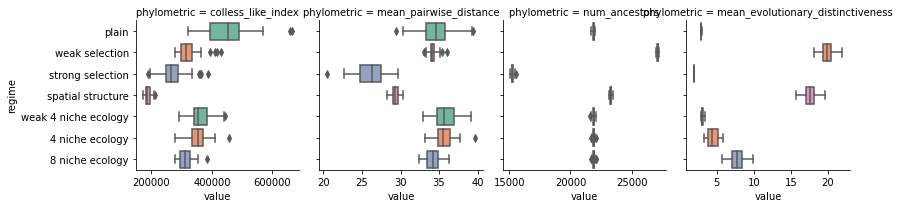

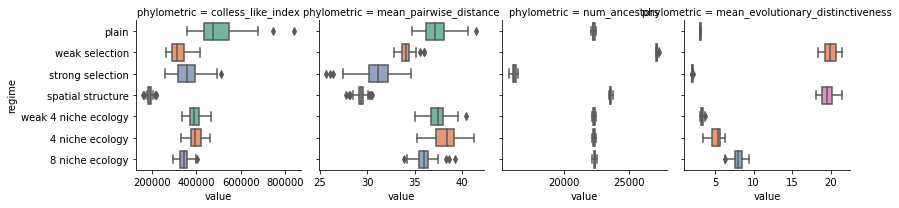

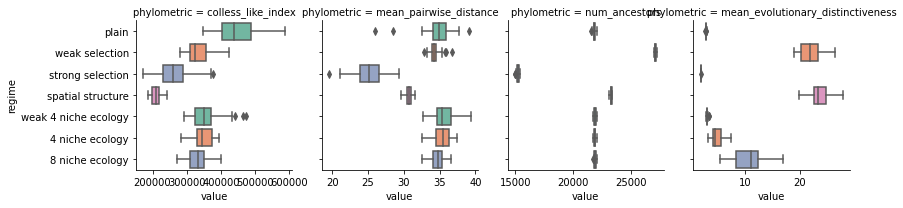

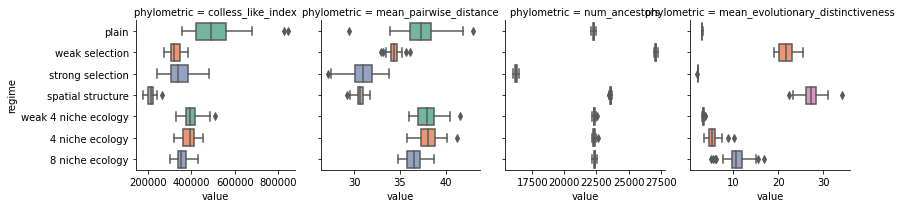

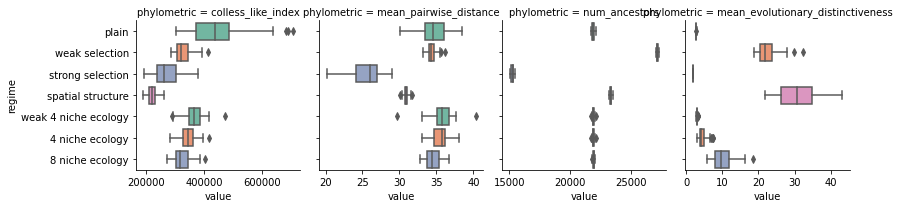

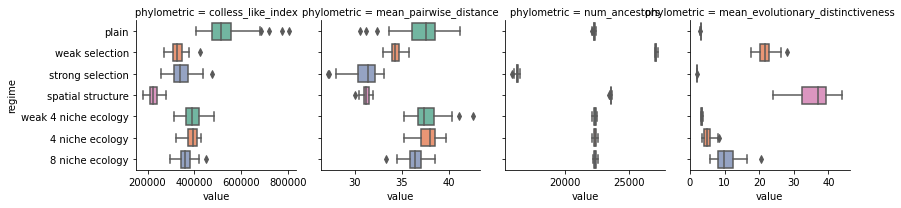

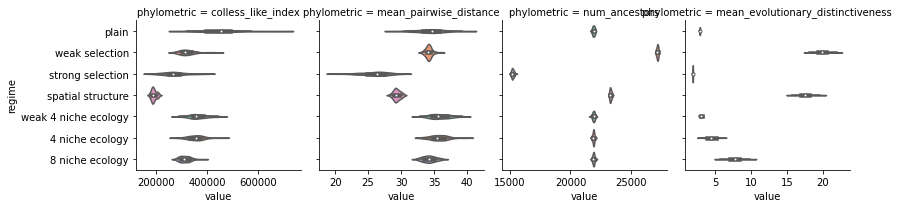

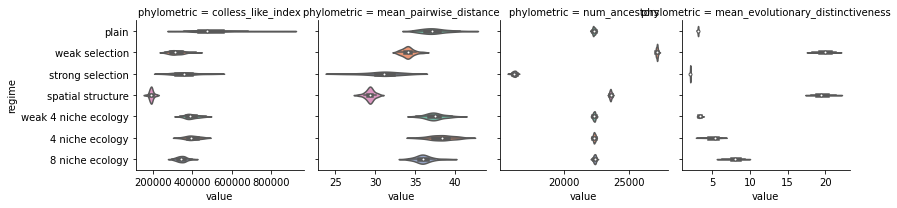

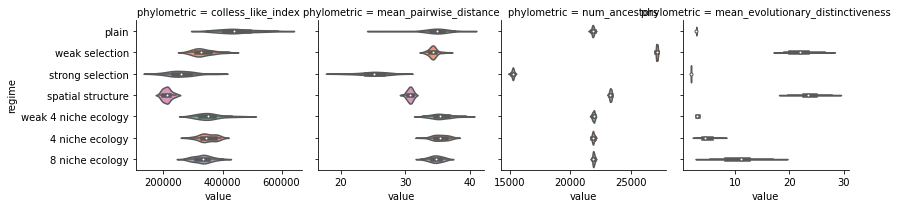

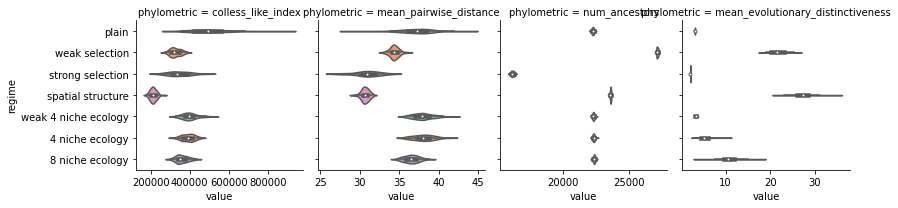

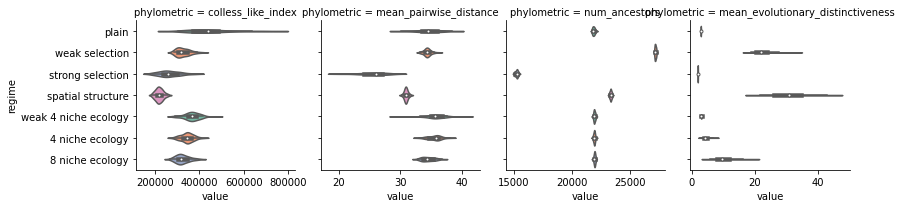

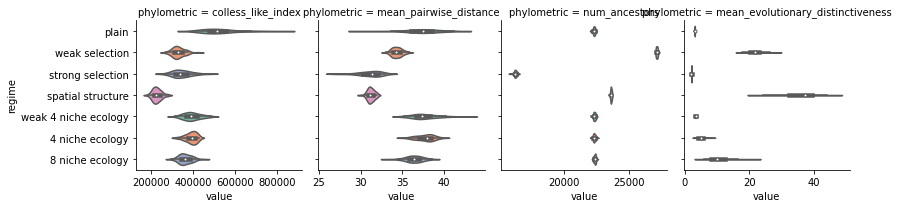

In [18]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        )
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ],
            palette=sns.color_palette("Set2", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


# regime heatmap signatures


teeplots/./epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=7+mut_distn=np.ra

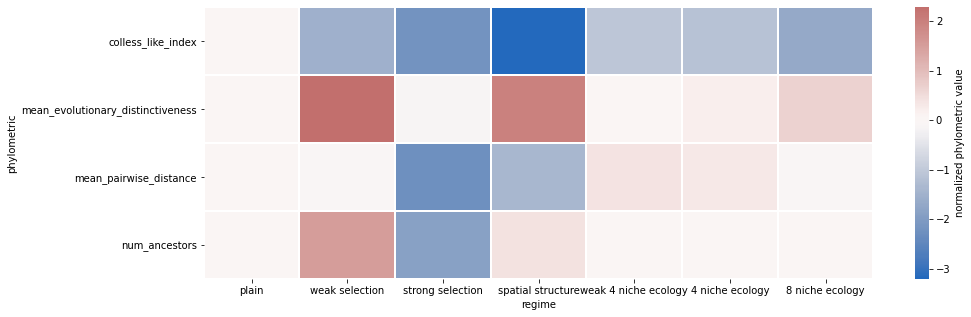

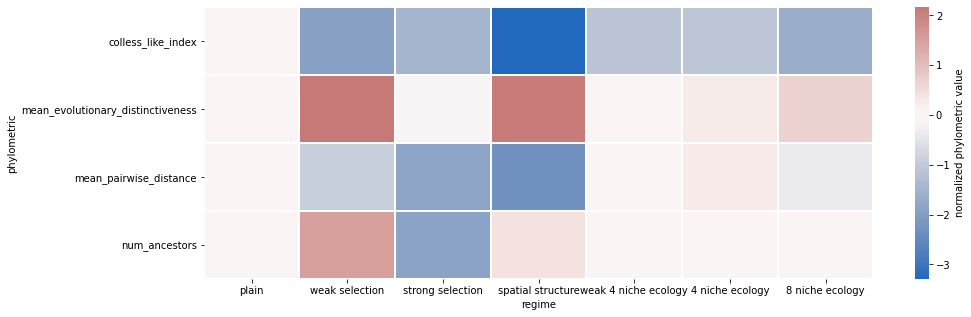

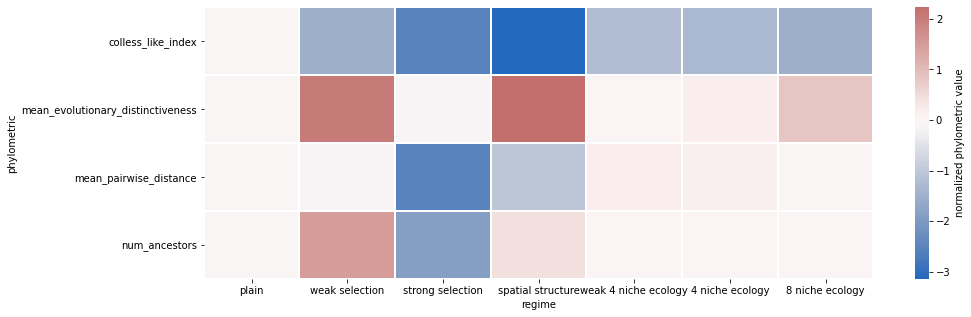

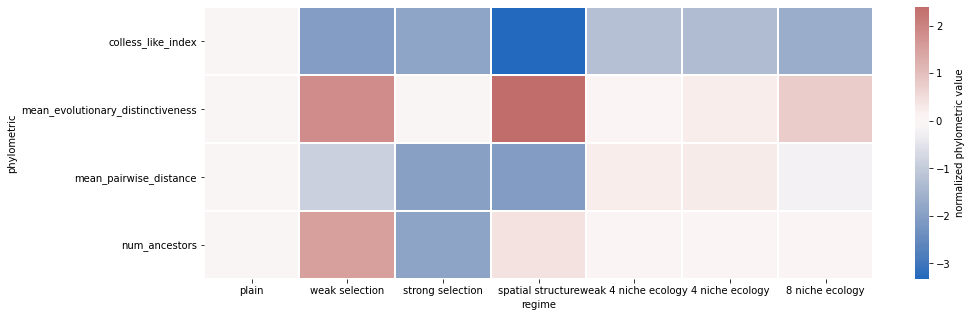

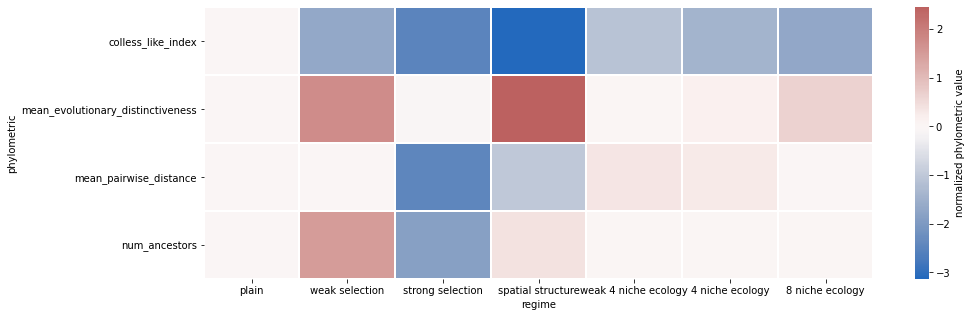

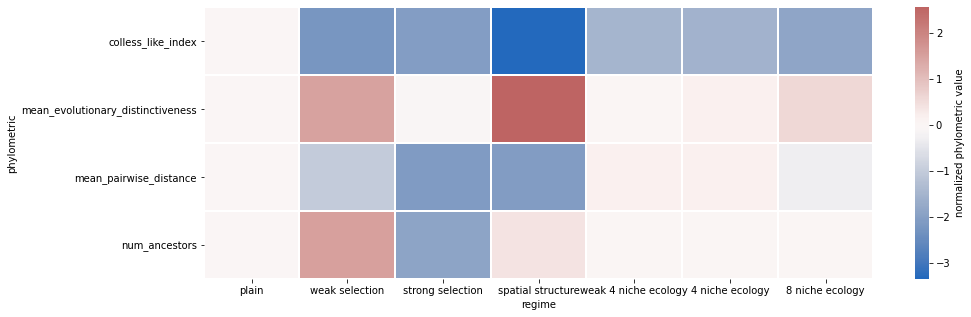

In [19]:
for (group, group_df) in df.groupby(sensitivity_analysis_variables):

    data = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    data = data.groupby("regime").mean()

    plain_means = data.loc["plain"]
    plain_stds = data.std()

    # normalize to plain
    for phylometric in phylometrics:
        data[phylometric] = (
            data[phylometric] - plain_means[phylometric]
        ) / plain_stds[phylometric]

    data = data.reset_index(drop=False)
    data

    melted_df = data.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]
    melted_df

    fig, ax = plt.subplots(figsize=(15, 5))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ].index,
        )
    ]

    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "normalized phylometric value"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
        },
    )


# stats: kruskal-wallis


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-kwallis+ext=.csv",
        index=False,
    )


,n,N,phylometric,statistic,p,epoch,mut_distn
0,50,7,colless_like_index,265.973064,1.576883e-54,0,np.random.exponential
1,50,7,mean_pairwise_distance,254.739684,3.980180e-52,0,np.random.exponential
2,50,7,num_ancestors,281.473486,7.599163e-58,0,np.random.exponential
3,50,7,mean_evolutionary_distinctiveness,340.178419,1.979817e-70,0,np.random.exponential
4,50,7,colless_like_index,266.181427,1.423079e-54,0,np.random.standard_normal
5,50,7,mean_pairwise_distance,290.996267,6.944132e-60,0,np.random.standard_normal
6,50,7,num_ancestors,285.014959,1.325953e-58,0,np.random.standard_normal
7,50,7,mean_evolutionary_distinctiveness,335.202247,2.314532e-69,0,np.random.standard_normal
8,50,7,colless_like_index,256.656035,1.549642e-52,2,np.random.exponential
9,50,7,mean_pairwise_distance,234.792635,7.262807e-48,2,np.random.exponential


# stats: wilcoxon all pairs


In [21]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["regime"] == regime1][phylometric],
                group_df[group_df["regime"] == regime2][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-wilcox+ext=.csv",
        index=False,
    )


,regime1,regime2,n,phylometric,statistic,p,epoch,mut_distn
0,4 niche ecology,8 niche ecology,50,colless_like_index,82.0,8.212512e-08,0,np.random.exponential
1,4 niche ecology,8 niche ecology,50,mean_pairwise_distance,120.0,5.866172e-07,0,np.random.exponential
2,4 niche ecology,8 niche ecology,50,num_ancestors,493.0,2.345368e-01,0,np.random.exponential
3,4 niche ecology,8 niche ecology,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
4,4 niche ecology,plain,50,colless_like_index,58.0,2.218011e-08,0,np.random.exponential
5,4 niche ecology,plain,50,mean_pairwise_distance,320.0,2.177312e-03,0,np.random.exponential
6,4 niche ecology,plain,50,num_ancestors,560.0,4.543665e-01,0,np.random.exponential
7,4 niche ecology,plain,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
8,4 niche ecology,spatial structure,50,colless_like_index,0.0,7.556929e-10,0,np.random.exponential
9,4 niche ecology,spatial structure,50,mean_pairwise_distance,0.0,7.556929e-10,0,np.random.exponential
